# Linear LFM

Replication of the paper by [Lawrence et al., 2006.](https://papers.nips.cc/paper/3119-modelling-transcriptional-regulation-using-gaussian-processes.pdf)

The dataset required is small and is available preprocessed here:

- https://drive.google.com/drive/folders/1Tg_3SlKbdv0pDog6k2ys0J79e1-vgRyd?usp=sharing

### Probesets

The original paper restricted their interest to 5 known targets of p53:

| Target       | Probeset     | Aliases    |
| :------------- | :----------: | :----------- |
| DDB2 |  203409_at    | |
| p21   | 202284_s_at | p21CIP1, CDKN1A |
| SESN1/hPA26   | 218346_s_at |  |
| BIK   | 205780_at |  |
| TNFRSF10b   | 209294_x_at, 209295_at, 210405_x_at |  |

In [1]:
import torch
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood

from lafomo.models import ExactLFM
from lafomo.trainer import ExactTrainer
from lafomo.datasets import P53Data
from lafomo.plot import Plotter

In [2]:
dataset = P53Data(replicate=0, data_dir='../../../data/')
model = ExactLFM(dataset, dataset.variance.reshape(-1))
optimizer = torch.optim.Adam(model.parameters(), lr=0.07)

loss_fn = ExactMarginalLogLikelihood(model.likelihood, model)

trainer = ExactTrainer(model, optimizer, dataset, loss_fn=loss_fn)
plotter = Plotter(model, dataset.gene_names)


In [4]:
model.likelihood.train()
trainer.train(epochs=40, report_interval=10)

Epoch 061/100 - Loss: 0.99 (0.99  ) λ: 0.7229584455490112
Epoch 071/100 - Loss: 0.75 (0.75  ) λ: 0.8795214891433716
Epoch 081/100 - Loss: 0.56 (0.56  ) λ: 1.288459062576294
Epoch 091/100 - Loss: 0.45 (0.45  ) λ: 1.264396071434021


torch.Size([5, 80])


C:\Users\Jacob\Documents\proj\lafomo\lafomo\plot\plotter.py:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(plotnum)


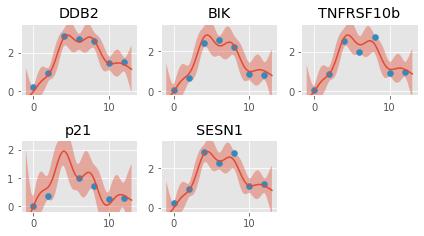

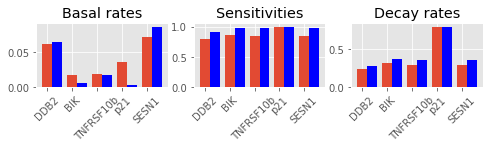

In [6]:
t_predict = torch.linspace(-1, 13, 80, dtype=torch.float64)

plotter.plot_outputs(t_predict, t_scatter=dataset.t_observed, y_scatter=dataset.m_observed)

# plotter.plot_latents(t_predict, ylim=(-2, 3.2), num_samples=1)

plotter.plot_kinetics()

In [ ]:
from matplotlib import pyplot as plt

Kxx = model.covar_module(model.train_t, model.train_t).evaluate()

plt.figure()
plt.imshow(Kxx.detach())
plt.axis('off')

Kxf = model.covar_module.K_xf(model.train_t, t_predict).type(torch.float64)

Kfx = torch.transpose(Kxf, 0, 1)
L = torch.cholesky(Kxx)

KxxKxf = torch.cholesky_solve(Kxf, L, upper=False)

# K_inv = torch.inverse(Kxx)

print(KxxKxf)
# KfxKxx = torch.matmul(torch.transpose(Kxf, 0, 1), K_inv)
# print(KfxKxx)
# mu = torch.matmul(KfxKxx, model.train_y).view(-1)
# plt.figure()
# plt.plot(mu.detach())

Kff = model.covar_module.K_ff(t_predict, t_predict)  # (100, 500)
plt.figure()
plt.imshow(Kff.detach())
plt.colorbar()
var = Kff - torch.matmul(Kfx, KxxKxf)
print(torch.diagonal(torch.matmul(Kfx, KxxKxf)).max())
print(torch.diagonal(var).min())
plt.figure()
plt.imshow(var.detach())
plt.colorbar()

plt.figure()
kfxf = torch.matmul(Kfx, KxxKxf)
print(kfxf)
plt.imshow(kfxf.detach())
plt.colorbar()


